Notebook con entrenamiento del modelo XGBoost con el dataframe con medias ponderadas

Autor: Mateo Turati

Descripción: Obtengo los datos de train, validación y test. Creo dos modelo de XGBoostClassifier usando  dos métodos de ajuste de hiperparámetros y estudio sus resultados

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "data", "processed","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2000-06-09,Kevin Randleman,Pedro Rizzo,False,0.0,0.8,0.279,0.315,0.770,0.000,...,0.0,0.0,0.8,0.0,-0.8,-0.036,0.615385,1.0,0.0,526.0
1,2000-09-22,Jeremy Horn,Eugene Jackson,False,0.0,0.5,0.696,0.550,0.084,0.000,...,0.0,0.5,0.0,0.0,-0.5,0.146,0.250000,0.4,0.0,3.3
2,2001-02-23,Tito Ortiz,Evan Tanner,False,0.3,0.0,0.552,0.741,0.874,1.000,...,0.0,0.0,0.0,0.0,0.3,-0.189,0.178571,-0.1,0.0,458.1
3,2001-05-04,Chuck Liddell,Kevin Randleman,False,0.0,0.0,0.508,0.532,0.000,0.758,...,1.0,0.0,0.0,1.0,0.0,-0.024,-0.518519,-1.5,0.2,-455.0
4,2001-06-29,Pat Miletich,Shonie Carter,False,0.0,1.0,0.451,0.521,0.500,0.646,...,0.5,0.0,0.0,0.0,-1.0,-0.070,0.037945,0.8,-1.2,-137.3


In [6]:
ruta_val = os.path.join("..","..", "data", "processed","validation.parquet")
df_val = pd.read_parquet(ruta_val)
df_val.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2021-06-26,Yancy Medeiros,Damir Hadzovic,True,0.0,0.0,0.261,0.323,0.000,0.432,...,1.0,0.5,1.5,1.8,0.0,-0.062,-0.368421,0.0,0.3,-59.5
1,2021-07-10,Tai Tuivasa,Greg Hardy,False,0.8,0.3,0.661,0.544,0.000,0.300,...,1.0,0.0,1.0,1.0,0.5,0.117,-0.230769,0.0,0.0,-20.0
2,2021-07-10,Irene Aldana,Yana Santos,False,0.3,0.0,0.367,0.731,0.000,0.150,...,0.0,0.0,3.5,0.0,0.3,-0.364,-0.187500,0.0,-0.2,-437.6
3,2021-07-10,Dustin Poirier,Conor McGregor,False,0.5,0.3,0.518,0.558,0.542,0.000,...,2.0,2.0,1.0,0.0,0.2,-0.040,0.222222,1.4,0.0,64.3
4,2021-07-10,Gilbert Burns,Stephen Thompson,False,0.2,0.3,0.547,0.467,0.075,0.000,...,0.0,0.0,2.0,3.0,-0.1,0.080,0.122449,0.3,0.0,140.9


In [7]:
ruta_test = os.path.join("..","..", "data", "processed","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-04-22,Rani Yahya,Montel Jackson,True,0.0,2.1,0.569,0.513,0.415,0.240,...,0.0,0.0,5.0,2.0,-2.1,0.056,0.047222,0.5,0.7,140.0
1,2023-04-22,Jeremiah Wells,Matthew Semelsberger,False,0.7,1.8,0.529,0.382,0.060,0.800,...,0.0,0.0,0.0,1.8,-1.1,0.147,-0.403226,0.3,0.0,-111.5
2,2023-04-29,Caio Borralho,Michal Oleksiejczuk,False,0.0,0.6,0.565,0.510,0.690,0.100,...,0.0,2.0,0.0,1.0,-0.6,0.055,0.370656,1.0,1.2,414.4
3,2023-04-29,Song Yadong,Ricky Simon,False,0.5,0.8,0.379,0.595,0.500,0.407,...,0.0,0.0,1.0,1.0,-0.3,-0.216,0.150000,-0.7,0.0,-244.9
4,2023-04-29,Rodolfo Vieira,Cody Brundage,False,0.0,0.3,0.528,0.214,0.305,0.700,...,1.0,0.0,0.5,1.0,-0.3,0.314,-0.393102,0.1,0.0,62.6


In [8]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.618167
True     0.381833
Name: proportion, dtype: float64

In [9]:
X_val = df_val.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_val = df_val["WINNER"]
y_val.value_counts(normalize=True)

WINNER
False    0.53167
True     0.46833
Name: proportion, dtype: float64

In [10]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.551724
True     0.448276
Name: proportion, dtype: float64

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

In [18]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Cuadrícula de hiperparámetros con y sin ajuste de pesos
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'gamma': [0, 0.1, 0.5],
        'min_child_weight': [3, 5],
        'scale_pos_weight': [1, scale_pos_weight]  # 1 = sin ajuste, otro valor = con ajuste
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_

In [19]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid = train_xgboost_grid(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': np.float64(1.618945102260495), 'subsample': 1.0}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.57      0.56      0.56       277
        True       0.51      0.52      0.51       244

    accuracy                           0.54       521
   macro avg       0.54      0.54      0.54       521
weighted avg       0.54      0.54      0.54       521



In [ ]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_val)
y_val_prob = best_grid.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5393474088291746
F1-Score: 0.5142
AUC-ROC: 0.5470
Precisión: 0.5080
Sensibilidad: 0.5205
Log-loss: 0.6946238333176036
[[154 123]
 [117 127]]


In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [11]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=5,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return random_search.best_estimator_

In [12]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
best_random = train_xgboost_random(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': np.float64(0.6), 'scale_pos_weight': 1, 'n_estimators': np.int64(50), 'min_child_weight': np.int64(3), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.1577777777777778), 'gamma': np.float64(0.2), 'colsample_bytree': np.float64(0.6)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.58      0.74      0.65       277
        True       0.58      0.40      0.47       244

    accuracy                           0.58       521
   macro avg       0.58      0.57      0.56       521
weighted avg       0.58      0.58      0.57       521



In [13]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_val)
y_val_prob = best_random.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.581573896353167
F1-Score: 0.4709
AUC-ROC: 0.5669
Precisión: 0.5774
Sensibilidad: 0.3975
Log-loss: 0.7221133695964453
[[206  71]
 [147  97]]


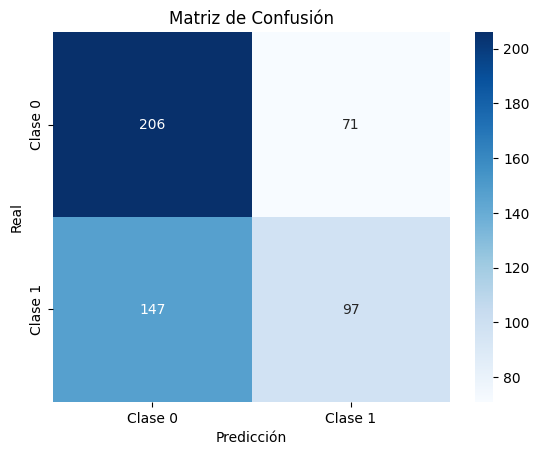

In [14]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Tras comparar ambas estrategias, observamos que GridSearchCV tiende a encontrar combinaciones de hiperparámetros más óptimas para mejorar el F1-score, ya que evalúa exhaustivamente todas las posibles combinaciones. Sin embargo, esto conlleva un mayor coste computacional. Por otro lado, RandomizedSearchCV, aunque no explora todas las combinaciones, logra un resultado competitivo con un tiempo de ejecución significativamente menor. En este caso, si bien el modelo obtenido con RandomizedSearchCV muestra un F1-score algo inferior, ha destacado en otras métricas como el accuracy, lo que sugiere que puede ser una alternativa eficiente dependiendo de las restricciones computacionales y los objetivos del modelo.